<a href="https://colab.research.google.com/github/ajk3158/HomeCollateralEstimationModel/blob/main/Home_Collateral_Estimation_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Home Collateral Estimation ML Model for banks to use in professional/personal financing operations through regression ML models, data prep/cleaning, and parameter hyper tuning. Wrote Technical Report on work and development process, which can be found [here](https://drive.google.com/file/d/1aqbg3fh1Q2kyIdrzz289N6eZIBCa5O-s/view?usp=sharing)



In [ ]:
import pandas as pd
import numpy as np

# Overview.

The purpose of this notebook is to predict land value for the purpose of helping consumers fairly acquire loans if they are able.

The data used in this notebook can be found [here](https://data.vbgov.com/dataset/property-sales/resource/4b8d0176-bb17-43e4-960c-59119ac5b091). The description of the columns are also there.

In [ ]:
!wget https://s3.amazonaws.com/vbgov-ckan-open-data/Property_Sales.csv

--2022-12-02 01:43:32--  https://s3.amazonaws.com/vbgov-ckan-open-data/Property_Sales.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.205, 54.231.194.120, 52.216.239.61, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82291366 (78M) [binary/octet-stream]
Saving to: ‘Property_Sales.csv.5’

Property_Sales.csv. 100%[===================>]  78.48M  59.1MB/s    in 1.3s    

2022-12-02 01:43:33 (59.1 MB/s) - ‘Property_Sales.csv.5’ saved [82291366/82291366]



In [ ]:
X = pd.read_csv('./Property_Sales.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
X.head()

,GPIN,Street Address,City,State,Zip Code,Neighborhood,Land Value,Improvement Value,Total Value,Land USE (Y/N),Sale Date,Sale Price,Document Number,Deed Book,Deed Page
0,24186722550000,1137 Cedar Point Dr,Virginia Beach,VA,23451-3843,Bay Colony,426800,330300,757100,No,01/04/1999,390000,000000000000000,3980,688
1,14899803230305,2140 Vista Cir 305,Virginia Beach,VA,23451-1070,Lesner Cove Condo,55300,461200,516500,No,02/04/2014,0,20140204000098340,NaN,NaN
2,14668344640000,5017 Bellamy Manor Dr,Virginia Beach,VA,23464-2710,Bellamy Manor-N,150000,224700,374700,No,01/10/2019,0,20190110000026860,NaN,NaN
3,24250181460000,905 Pendergrass Ct,Virginia Beach,VA,23454-6816,Ocean Lakes/Culver Acres,113000,259600,372600,No,11/16/2020,359000,202000105981,NaN,NaN
4,14758746114302,4359 Atwater Arch,Virginia Beach,VA,23456-1442,Lake Princess Anne Condos,25000,114400,139400,No,08/01/2018,8000000,20180801000630560,NaN,NaN


# Data Cleaning

I want to get rid of the sale price column as we are looking at total value and those will correlate too much. I want to be able to predict the value without the price. Document number, Deed Book and Page, GPIN, and Street address are unnecessary. City and State as well, because they are the same for every value.

In [ ]:
# Drop useless columns
features_to_remove = ['GPIN', 'Street Address', 'Document Number', 'Sale Price', 'City', 'State', 'Deed Book', 'Deed Page']
for feature in features_to_remove:
    if feature in X.columns:
        X = X.drop(feature, axis=1)
print(f'Columns left: {X.columns}')

Columns left: Index(['Zip Code', 'Neighborhood', 'Land Value', 'Improvement Value',
       'Total Value', 'Land USE (Y/N)', 'Sale Date'],
      dtype='object')


Split into X and y

In [ ]:
# Drop Total Value, set that to y
from sklearn.model_selection import train_test_split
if 'Total Value' in X.columns:
    y = X['Total Value']
    X = X.drop('Total Value', axis = 1)
# Convert this to datetime
if 'Sale Date' in X.columns:
    X['Sale Date'] = pd.to_datetime(X['Sale Date'], infer_datetime_format=True)
    # Create year and month columns from datetime
    X['Year'] = X['Sale Date'].apply(lambda time: time.year)
    X['Month'] = X['Sale Date'].apply(lambda time: time.month)
    X.drop('Sale Date', axis = 1, inplace = True)
X.head()

,Zip Code,Neighborhood,Land Value,Improvement Value,Land USE (Y/N),Year,Month
0,23451-3843,Bay Colony,426800,330300,No,1999.0,1.0
1,23451-1070,Lesner Cove Condo,55300,461200,No,2014.0,2.0
2,23464-2710,Bellamy Manor-N,150000,224700,No,2019.0,1.0
3,23454-6816,Ocean Lakes/Culver Acres,113000,259600,No,2020.0,11.0
4,23456-1442,Lake Princess Anne Condos,25000,114400,No,2018.0,8.0


Let's investigate the data types of each of these.

* Categorical columns - Zip Code, Land Use
* Numerical columns - Improvement Value, Land Value, Year, Month

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


cat_cols = ['Zip Code', 'Land USE (Y/N)']
num_cols = ['Land Value', 'Year', 'Month'] #rm improvement value, too valuable
for col in num_cols:
    X[col] = pd.to_numeric(X[col], errors = 'coerce')

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ('imputer', SimpleImputer(strategy="median"))
    ])

cat_pipeline = Pipeline([
    ('imputer', DataFrameImputer()),
    ('encoder', OrdinalEncoder())
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ])
# One Hot encoding creates way too many columns, so we'll use a target encoder
X_cleaned = full_pipeline.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size = 0.2)
X = pd.DataFrame(X_cleaned, columns = num_cols + cat_cols)


## Feature Correlations

Hover over the boxes to view the actual value. We. learn from this matrix that improvement value and total value have almost a perfect positive correlation.

In [ ]:
# Let's visualize the correlation between features now.
from pandas.plotting import scatter_matrix
import plotly.express as px
from copy import copy

X_with_labels = copy(X)
X_with_labels['Total Value'] = y
# scatter_matrix(data[data.columns], figsize=(20, 15))
px.imshow(X_with_labels.corr())

# Simple Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
def score(reg_):
    scores = -1 * cross_val_score(reg_, X_test, y_test, scoring = 'neg_root_mean_squared_error')
    avg_rmse_score = np.mean(scores)
    print(f"Average RMSE: $ {np.round(avg_rmse_score, 2)}")

In [ ]:
score(reg)

Average RMSE: $ 1039270.33


Above, you can see the cross validation scores for the linear regression.

# Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
tree_reg_ = DecisionTreeRegressor(max_depth=2)
# Tune
tree_reg = RandomizedSearchCV(estimator = tree_reg_, param_distributions = dict(max_depth=[1, 10, 20, 100], max_leaf_nodes=[5, 10, 15, 20, 30]), cv = 3, scoring = 'neg_root_mean_squared_error')
tree_reg.fit(X_train, y_train)
score(tree_reg)

Average RMSE: $ 997424.89


# AdaBoost Ensemble Regressor

In [ ]:
X

,Land Value,Year,Month,Zip Code,Land USE (Y/N)
0,0.490807,-0.165768,-1.694949,1537.0,0.0
1,-0.224719,0.550194,-1.395687,62.0,0.0
2,-0.042322,0.788847,-1.694949,17734.0,0.0
3,-0.113586,0.836578,1.297672,9106.0,0.0
4,-0.283078,0.741117,0.399885,11967.0,0.0
...,...,...,...,...,...
557931,-0.117438,0.407001,-0.497901,3924.0,0.0
557932,0.102131,0.932040,-0.497901,11772.0,0.0
557933,-0.123216,0.120616,-1.096425,9328.0,0.0
557934,-0.123216,0.120616,-1.096425,9328.0,0.0


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor(n_estimators = 50)
abr.fit(X_train, y_train)

AdaBoostRegressor()

In [ ]:
score(abr)

Average RMSE: $ 1044717.0


# Clustering

Let's see if we can find patterns on the zip code

In [ ]:
!wget https://gist.github.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data

--2022-12-02 01:44:21--  https://gist.github.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data
Resolving gist.github.com (gist.github.com)... 140.82.113.3
Connecting to gist.github.com (gist.github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data [following]
--2022-12-02 01:44:21--  https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiti

In [ ]:
!ls

 Property_Sales.csv     sample_data
 Property_Sales.csv.1  'US Zip Codes from 2013 Government Data'
 Property_Sales.csv.2  'US Zip Codes from 2013 Government Data.1'
 Property_Sales.csv.3  'US Zip Codes from 2013 Government Data.2'
 Property_Sales.csv.4  'US Zip Codes from 2013 Government Data.3'
 Property_Sales.csv.5


In [ ]:
zipdata = pd.read_csv('US Zip Codes from 2013 Government Data')
zipdata.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [ ]:
# Truncate dashes in X
X['Zip Code'] = X['Zip Code'].astype(int)
X.head()

,Land Value,Year,Month,Zip Code,Land USE (Y/N)
0,0.490807,-0.165768,-1.694949,1537,0.0
1,-0.224719,0.550194,-1.395687,62,0.0
2,-0.042322,0.788847,-1.694949,17734,0.0
3,-0.113586,0.836578,1.297672,9106,0.0
4,-0.283078,0.741117,0.399885,11967,0.0


In [ ]:
zipdata['Zip Code'] = zipdata['ZIP']
zipdata.drop('ZIP', axis = 1, inplace = True)
zipdata.head()

,LAT,LNG,Zip Code
0,18.180555,-66.749961,601
1,18.361945,-67.175597,602
2,18.455183,-67.119887,603
3,18.158345,-66.932911,606
4,18.295366,-67.125135,610


In [ ]:
X = pd.merge(zipdata, X_with_labels, on = "Zip Code", how = "inner")
X.head()

,LAT,LNG,Zip Code,Land Value,Year,Month,Land USE (Y/N),Total Value
0,18.180555,-66.749961,601,-0.331229,0.072886,0.100623,0.0,0
1,18.361945,-67.175597,602,0.716347,0.836578,-1.395687,0.0,807200
2,18.361945,-67.175597,602,0.846163,-0.643076,0.998410,0.0,915800
3,18.361945,-67.175597,602,1.588846,-0.452153,-0.198639,0.0,1256900
4,18.361945,-67.175597,602,0.580176,-0.165768,-1.694949,0.0,852200


In [ ]:
x = X['Total Value']
x = x[x.between(x.quantile(.15), x.quantile(.85))] # without outliers
X['Total Value'] = x

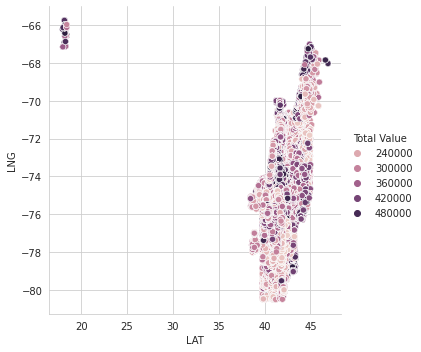

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.relplot(x='LAT', y='LNG', hue='Total Value', data=X);